# Test validity step 3 : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$ becoming $P(r | ...) \propto s_c^t C(r)^{-1} s_c + ln|C(r)|$

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


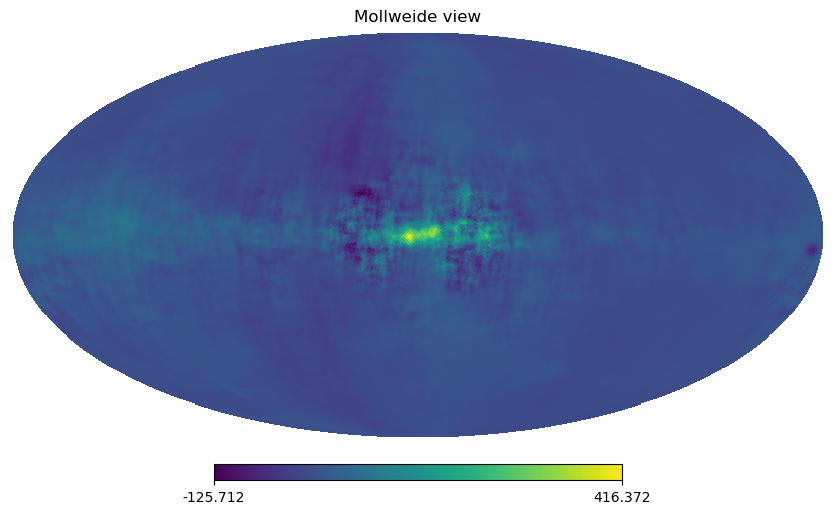

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:nstokes]

In [7]:
# input_cmb_maps_extended = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]),input_cmb_maps[0]])
# initial_spectra = hp.anafast(input_cmb_maps_extended, lmax=lmax, iter=n_iter)
# initial_spectra[0,:] = 0
# initial_spectra[nstokes+2:,:] = 0

# c_ells_input = np.zeros((6,lmax+1))
# c_ell_approx = np.zeros((6,lmax+1))


# c_ells_input[:4,...] = initial_spectra[:4,:]
# c_ell_approx[1] = initial_spectra[1,:]
# c_ell_approx[2] = initial_spectra[2,:]

# # c_ells_input[:4,...] = camb_cls.T
# # c_ell_approx[1] = camb_cls.T[1]
# # c_ell_approx[2] = lensing_spectra.T[2]



In [8]:
all_spectra = generate_power_spectra_CAMB(nside*2, r=0, typeless_bool=True)
all_spectra_r0 = generate_power_spectra_CAMB(nside*2, r=0, typeless_bool=True)
all_spectra_r1 = generate_power_spectra_CAMB(nside*2, r=1, typeless_bool=True)
all_spectra_r2 = generate_power_spectra_CAMB(nside*2, r=.1, typeless_bool=True)


Calculating spectra from CAMB !
Calculating spectra from CAMB !
Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [9]:
lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,partial_indices_polar]
tensor_spectra = all_spectra['tensor'][:lmax+1,partial_indices_polar]
lens_potential_spectra = all_spectra['lens_potential'][:lmax+1,partial_indices_polar]
camb_cls = all_spectra['total'][:lmax+1,partial_indices_polar]
unlensed_scalar_spectra = all_spectra['unlensed_scalar'][:lmax+1,partial_indices_polar]
unlensed_total_spectra = all_spectra['unlensed_total'][:lmax+1,partial_indices_polar]

lensing_spectra_r0 = all_spectra_r0['lensed_scalar'][:lmax+1,partial_indices_polar]
tensor_spectra_r0 = all_spectra_r0['tensor'][:lmax+1,partial_indices_polar]
lens_potential_spectra_r0 = all_spectra_r0['lens_potential'][:lmax+1,partial_indices_polar]
camb_cls_r0 = all_spectra_r0['total'][:lmax+1,partial_indices_polar]
unlensed_scalar_spectra_r0 = all_spectra_r0['unlensed_scalar'][:lmax+1,partial_indices_polar]
unlensed_total_spectra_r0 = all_spectra_r0['unlensed_total'][:lmax+1,partial_indices_polar]

lensing_spectra_r1 = all_spectra_r1['lensed_scalar'][:lmax+1,partial_indices_polar]
tensor_spectra_r1 = all_spectra_r1['tensor'][:lmax+1,partial_indices_polar]
lens_potential_spectra_r1 = all_spectra_r1['lens_potential'][:lmax+1,partial_indices_polar]
camb_cls_r1 = all_spectra_r1['total'][:lmax+1,partial_indices_polar]
unlensed_scalar_spectra_r1 = all_spectra_r1['unlensed_scalar'][:lmax+1,partial_indices_polar]
unlensed_total_spectra_r1 = all_spectra_r1['unlensed_total'][:lmax+1,partial_indices_polar]

lensing_spectra_r2 = all_spectra_r2['lensed_scalar'][:lmax+1,partial_indices_polar]
tensor_spectra_r2 = all_spectra_r2['tensor'][:lmax+1,partial_indices_polar]
lens_potential_spectra_r2 = all_spectra_r2['lens_potential'][:lmax+1,partial_indices_polar]
camb_cls_r2 = all_spectra_r2['total'][:lmax+1,partial_indices_polar]
unlensed_scalar_spectra_r2 = all_spectra_r2['unlensed_scalar'][:lmax+1,partial_indices_polar]
unlensed_total_spectra_r2 = all_spectra_r2['unlensed_total'][:lmax+1,partial_indices_polar]


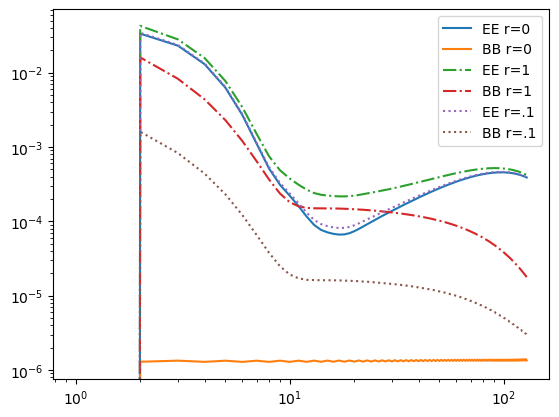

In [10]:
ell_arange = np.arange(lensing_spectra.shape[0])
plt.plot(ell_arange, camb_cls)
plt.plot(ell_arange, camb_cls_r1, '-.')
plt.plot(ell_arange, camb_cls_r2, ':')
plt.loglog()
# plt.legend(['TT','EE','BB','TE', 'TT','EE','BB','TE', 'TT','EE','BB','TE'])
plt.legend(['EE r=0','BB r=0','EE r=1','BB r=1','EE r=.1','BB r=.1'])
plt.show()

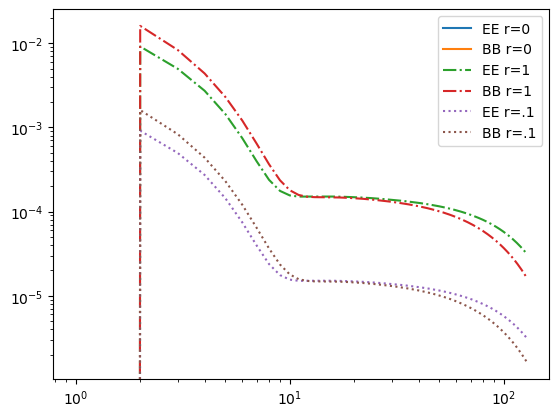

In [11]:
ell_arange = np.arange(lensing_spectra.shape[0])
plt.plot(ell_arange, tensor_spectra)
plt.plot(ell_arange, tensor_spectra_r1, '-.')
plt.plot(ell_arange, tensor_spectra_r2, ':')
plt.loglog()
plt.legend(['EE r=0','BB r=0','EE r=1','BB r=1','EE r=.1','BB r=.1'])
plt.show()

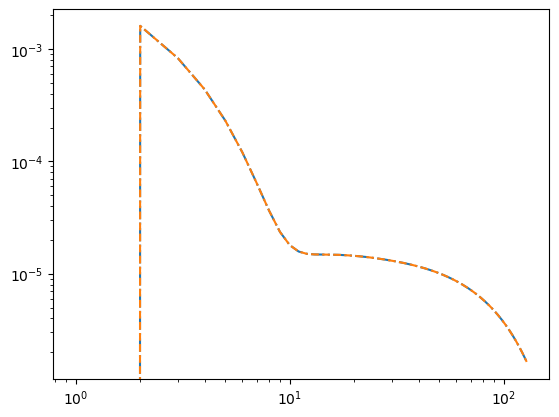

In [12]:
ell_arange = np.arange(lensing_spectra.shape[0])
plt.plot(ell_arange, tensor_spectra_r1[:,1]*.1, '-.')
plt.plot(ell_arange, tensor_spectra_r2[:,1], '--')
plt.loglog()
# plt.legend()
plt.show()

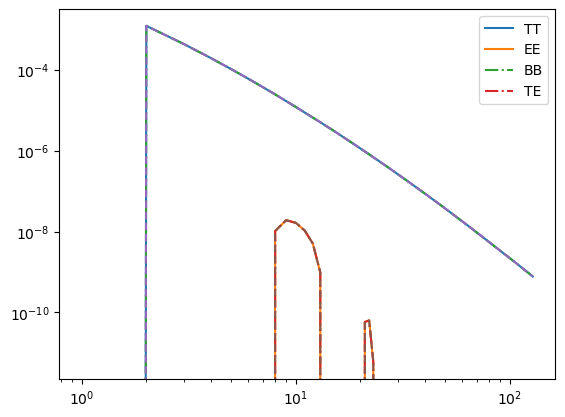

In [13]:
ell_arange = np.arange(lensing_spectra.shape[0])
plt.plot(ell_arange, lens_potential_spectra)
plt.plot(ell_arange, lens_potential_spectra_r1, '-.')
plt.plot(ell_arange, lens_potential_spectra_r2, '--')
plt.loglog()
plt.legend(['TT','EE','BB','TE'])
plt.show()

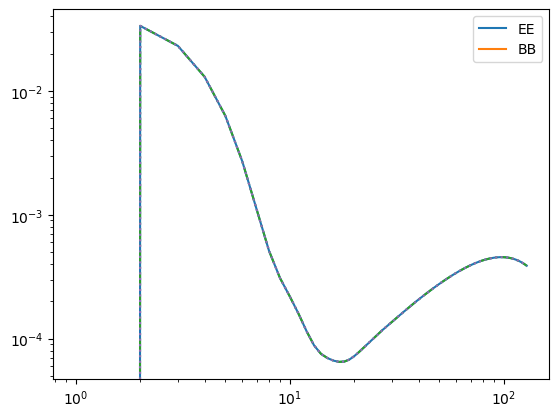

In [14]:
ell_arange = np.arange(lensing_spectra.shape[0])
plt.plot(ell_arange, unlensed_scalar_spectra)
plt.plot(ell_arange, unlensed_scalar_spectra_r1, '-.')
plt.plot(ell_arange, unlensed_scalar_spectra_r2, ':')
plt.loglog()
plt.legend(['EE','BB'])
plt.show()

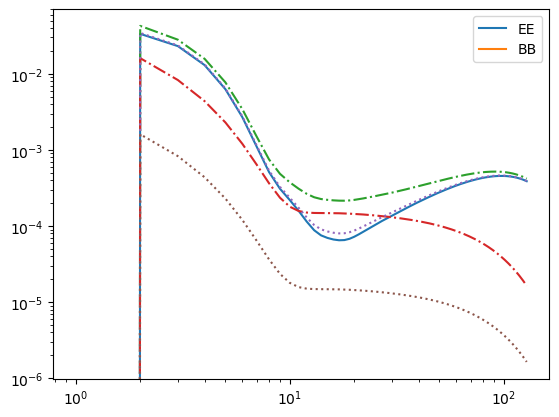

In [15]:
ell_arange = np.arange(lensing_spectra.shape[0])
plt.plot(ell_arange, unlensed_total_spectra)
plt.plot(ell_arange, unlensed_total_spectra_r1, '-.')
plt.plot(ell_arange, unlensed_total_spectra_r2, ':')
plt.loglog()
plt.legend(['EE','BB'])
plt.show()

In [16]:
# indices_polar = np.array([1,2,4])

# if nstokes == 2:    
#     c_ells_input = c_ells_input[indices_polar,:]
#     c_ell_approx = c_ell_approx[indices_polar,:]
#     # CMB_map_input = CMB_map_input[1:,:]
#     # freq_maps = freq_maps[:,1:,:]

In [17]:
depth_p = instrument['depth_p']

freq_inverse_noise = micmac.get_noise_covar(depth_p, nside)

init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[0,-1])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[0,-1])

mixing_matrix_sampled = mixing_matrix_obj.get_B()

cp_cp_noise = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [18]:
a_test = np.array([[1,0],[0,-1]])
a_array = np.repeat(a_test, 4).reshape((4,2,2),order='F')
np.linalg.det(a_array)

array([-1., -1., -1., -1.])

In [19]:
def get_conditional_proba_C_from_r(r_param, **model_kwargs):
    red_sigma_ell = model_kwargs['red_sigma_ell']

    # red_cov_matrix_sampled = model_kwargs['red_cov_matrix_sampled']
    red_cov_matrix_sampled = r_param * model_kwargs['theoretical_red_cov_r1_tensor'] + model_kwargs['theoretical_red_cov_r0_total']

    sum_dets = ( (2*jnp.arange(model_kwargs['lmin'], model_kwargs['lmax']+1) +1) * jnp.log(jnp.linalg.det(red_cov_matrix_sampled)) ).sum()
    
    return -( jnp.einsum('lij,lji->l', red_sigma_ell, jnp.linalg.pinv(red_cov_matrix_sampled)).sum() + sum_dets)/2
    # return -(jnp.einsum('lij,lji->l', red_sigma_ell, jnp.linalg.pinv(red_cov_matrix_sampled)).sum() + 0)/2
    # return -(sum_dets)/2


def get_sample_parameter(mcmc_kernel, full_initial_guess, random_PRNGKey=random.PRNGKey(100), **model_kwargs):
    
    # mcmc.run(random.PRNGKey(0), init_params=full_initial_guess, pos_special_freqs=jnp.array(mixing_matrix_obj.pos_special_freqs), full_data_without_CMB=jnp.array(full_data_without_CMB), modified_sample_eta_maps=jnp.array(modified_sample_eta_maps_v2), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints)
    mcmc_kernel.run(random_PRNGKey, init_params=full_initial_guess, **model_kwargs)
    
    mcmc_kernel.print_summary()

    return mcmc_kernel.get_samples(group_by_chain=True)

In [20]:
r_true = 0.0
r_true = 10**(-3)

only_select_Bmodes = True

theoretical_r1_tensor = np.zeros((number_correlations,lmax+1))
theoretical_r0_total = np.zeros_like(theoretical_r1_tensor)
# theoretical_r1_tensor[:nstokes,...] = tensor_spectra_r1[:,partial_indices_polar].T
# # theoretical_r0_total[:nstokes,...] = camb_cls_r0[:,partial_indices_polar].T
# theoretical_r0_total[:nstokes,...] = unlensed_scalar_spectra_r0[:,partial_indices_polar].T
theoretical_r1_tensor[:nstokes,...] = tensor_spectra_r1.T
# theoretical_r0_total[:nstokes,...] = camb_cls_r0.T
theoretical_r0_total[:nstokes,...] = unlensed_scalar_spectra_r0.T

theoretical_red_cov_r1_tensor = micmac.get_reduced_matrix_from_c_ell(theoretical_r1_tensor)[lmin:]
theoretical_red_cov_r0_total = micmac.get_reduced_matrix_from_c_ell(theoretical_r0_total)[lmin:]

if only_select_Bmodes:
    c_ell_select_only_Bmodes = np.zeros((6,lmax+1))
    c_ell_select_only_Bmodes[2,lmin:] = 1
    red_cov_select_Bmodes = micmac.get_reduced_matrix_from_c_ell(c_ell_select_only_Bmodes[indices_polar,...])[lmin:,...]

    theoretical_red_cov_r1_tensor = np.einsum('lkj,ljm->lkm', red_cov_select_Bmodes, theoretical_red_cov_r1_tensor)
    theoretical_red_cov_r0_total = np.einsum('lkj,ljm->lkm', red_cov_select_Bmodes, theoretical_red_cov_r0_total)
    theoretical_red_cov_r1_tensor[:,:,0] = 0
    theoretical_red_cov_r0_total[:,:,0] = 0
    theoretical_red_cov_r1_tensor[:,0,0] = 10**(-30)
    theoretical_red_cov_r0_total[:,0,0] = 10**(-30)

true_cmb_specra = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + r_true*theoretical_red_cov_r1_tensor)
true_cmb_specra_extended = np.zeros((6,lmax+1-lmin))
true_cmb_specra_extended[indices_polar,...] = true_cmb_specra

input_cmb_maps_alt = hp.synfast(true_cmb_specra_extended, nside=nside, new=True, lmax=lmax)[1:,...]

if only_select_Bmodes:
    input_cmb_maps_alt = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(np.copy(input_cmb_maps_alt), red_cov_select_Bmodes, lmin=2, n_iter=n_iter)

# input_cmb_maps = np.repeat(input_cmb_maps_alt, number_frequencies).reshape((number_frequencies,nstokes,npix),order='F')
input_cmb_maps = np.repeat(input_cmb_maps_alt.ravel(order='F'), number_frequencies).reshape((number_frequencies,nstokes,npix),order='F')
# input_cmb_maps = np.tile(input_cmb_maps_alt.ravel(order='F'),number_frequencies).reshape((number_frequencies, nstokes, npix))
# input_cmb_maps = np.array([input_cmb_maps_alt for i in range(number_frequencies)])
freq_maps = input_cmb_maps + freq_maps_fgs

if only_select_Bmodes:
    for freq in range(number_frequencies):
        freq_maps[freq] = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(np.copy(freq_maps[freq]), red_cov_select_Bmodes, lmin=2, n_iter=n_iter)[1:,...]



In [21]:
path_Fisher = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/fisher_so-sat_d0s0_lmin2_lmax128_nomask_Alens1.0_r0.0_B_noiselens.txt'
Fisher_matrix = np.loadtxt(path_Fisher)

pos_special_freqs = [0,-1]

init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=pos_special_freqs)
init_params = init_mixing_matrix_obj.init_params()


minimum_std_Fisher = scipy.linalg.sqrtm(np.linalg.inv(Fisher_matrix))
minimum_std_Fisher_diag = np.diag(minimum_std_Fisher)


len_pos_special_freqs = len(pos_special_freqs)
step_size_array = np.zeros(((number_frequencies-len_pos_special_freqs)*2))
step_size_array[:number_frequencies-len_pos_special_freqs] = minimum_std_Fisher_diag[:number_frequencies-len_pos_special_freqs]
step_size_array[number_frequencies-len_pos_special_freqs:] = minimum_std_Fisher_diag[number_frequencies-len_pos_special_freqs:2*(number_frequencies-len_pos_special_freqs)]

params_mixing_matrix_sample = init_params.ravel(order='F') + 10*np.random.uniform(low=-step_size_array,high=step_size_array, size=((number_frequencies-len_pos_special_freqs)*2))

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], number_components, params_mixing_matrix_sample.reshape(((number_frequencies-len_pos_special_freqs),2),order='F'), pos_special_freqs=pos_special_freqs)
mixing_matrix_sampled = mixing_matrix_obj.get_B()


freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p'], nside)
BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], number_components, params_mixing_matrix_sample.reshape(((number_frequencies-len_pos_special_freqs),2),order='F'), pos_special_freqs=pos_special_freqs)
mixing_matrix_sampled = mixing_matrix_obj.get_B()

In [22]:
true_red_cov_cmb_specra = micmac.get_reduced_matrix_from_c_ell(true_cmb_specra)

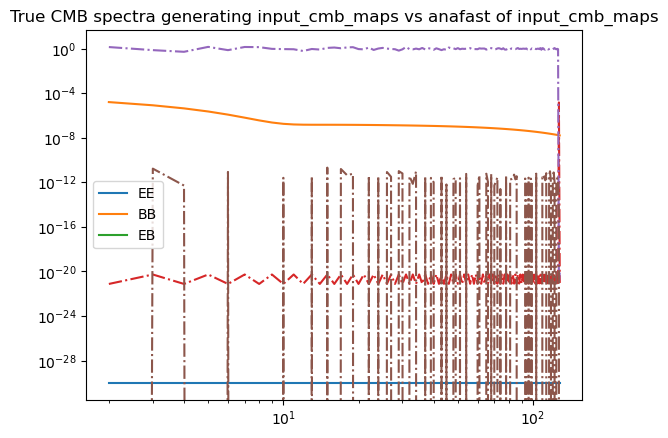

In [23]:
true_cmb_specra_extended[4,lmin:] = np.random.choice([1,-1],size=(lmax+1-2*lmin))*10**(-15)


# c_ells_anafast = hp.anafast(input_cmb_maps_alt_2, lmax=lmax, iter=20)[indices_polar,lmin:]
input_cmb_maps_alt_2 = hp.synfast(true_cmb_specra_extended, nside=nside, new=True, lmax=lmax)
c_ells_anafast = hp.anafast(input_cmb_maps_alt_2, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
# input_cmb_maps_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0]),input_cmb_maps[0]])
# c_ells_input_cmb = hp.anafast(input_cmb_maps_ext,lmax=lmax,iter=n_iter)[indices_polar,lmin:]

plt.plot(np.arange(true_cmb_specra_extended.shape[-1])+lmin,true_cmb_specra.T)
plt.plot(np.arange(c_ells_anafast.shape[-1])+lmin,c_ells_anafast.T, '-.')
# plt.plot(np.arange(true_cmb_specra_extended.shape[-1]),true_cmb_specra_extended.T)
# plt.plot(np.arange(c_ells_anafast.shape[-1]),c_ells_anafast.T, '-.')
# plt.plot(np.arange(c_ells_anafast.shape[-1]),c_ells_input_cmb.T, ':')
plt.loglog()
# plt.legend(['TT','EE','BB','TE','EB','TB'])
plt.legend(['EE','BB','EB'])
plt.title('True CMB spectra generating input_cmb_maps vs anafast of input_cmb_maps')
plt.show()

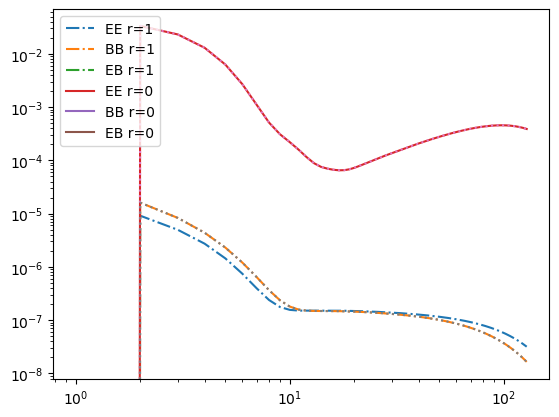

In [24]:
plt.plot(np.arange(theoretical_r1_tensor.shape[-1]),theoretical_r1_tensor.T*r_true, '-.')
plt.plot(np.arange(theoretical_r1_tensor.shape[-1]),theoretical_r0_total.T)
plt.plot(np.arange(theoretical_r1_tensor.shape[-1]), (theoretical_r0_total + r_true*theoretical_r1_tensor).T, ':')
plt.loglog()
plt.legend(['EE r=1','BB r=1','EB r=1', 'EE r=0','BB r=0','EB r=0'])
plt.show()

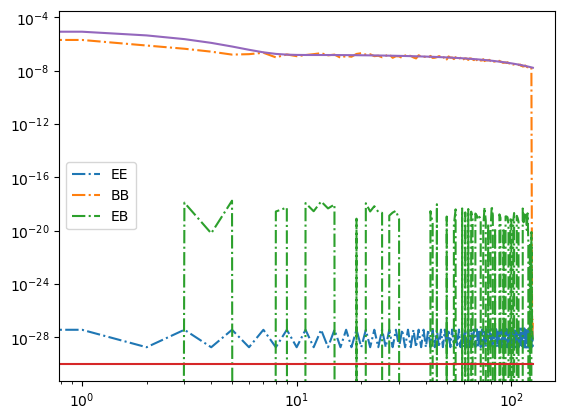

In [25]:
input_cmb_maps_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0]),input_cmb_maps[0]])

c_ells_input_cmb = hp.anafast(input_cmb_maps_ext,lmax=lmax,iter=n_iter)[indices_polar,lmin:]

plt.plot(np.arange(c_ells_input_cmb.shape[-1]),c_ells_input_cmb.T, '-.')
plt.plot(np.arange(true_cmb_specra.shape[-1]),true_cmb_specra.T)
plt.loglog()
plt.legend(['EE','BB','EB'])
plt.show()

In [26]:
s_cML = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0,...]

if only_select_Bmodes:
    s_cML = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(np.copy(s_cML), red_cov_select_Bmodes, lmin=2, n_iter=n_iter)#[1:,...]

In [27]:
red_cov_matrix_sample = true_red_cov_cmb_specra
iteration = 0

if only_select_Bmodes:
    red_cov_matrix_sample = np.einsum('lkj,ljm->lkm', red_cov_select_Bmodes, red_cov_matrix_sample)
    red_cov_matrix_sample[:,:,0] = 0

# Sampling step 2 : sampling of Gaussian variable s_c 
initial_guess_WF = np.empty(0)
time_start_sampling_s_c_WF = time.time()
wiener_filter_term = micmac.solve_generalized_wiener_filter_term(param_dict, s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=initial_guess_WF, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
time_sampling_s_c_WF = (time.time()-time_start_sampling_s_c_WF)/60
print("##### Sampling s_c_WF at iteration {} in {} minutes".format(iteration+1, time_sampling_s_c_WF), flush=True)

initial_guess_fluct = np.empty(0)
map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
map_random_realization_chi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))
time_start_sampling_s_c_fluct = time.time()
fluctuation_maps = micmac.get_fluctuating_term_maps(param_dict, red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess_fluct, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
time_sampling_s_c_fluct = (time.time()-time_start_sampling_s_c_fluct)/60
print("##### Sampling s_c_fluct at iteration {} in {} minutes".format(iteration+1, time_sampling_s_c_fluct), flush=True)

if only_select_Bmodes:
    fluctuation_maps = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(np.copy(fluctuation_maps), red_cov_select_Bmodes, lmin=2, n_iter=n_iter)#[1:,...]


# if only_select_Bmodes:
#     fluctuation_maps = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(np.copy(fluctuation_maps), red_cov_select_Bmodes, lmin=2, n_iter=n_iter)#[1:,...]

s_c_sample = wiener_filter_term + fluctuation_maps

CG-Python-0 WF finished in  144 iterations !!
##### Sampling s_c_WF at iteration 1 in 0.060185468196868895 minutes
CG-Python-0 Fluct finished in  284 iterations !!
##### Sampling s_c_fluct at iteration 1 in 0.10745851596196493 minutes


In [28]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


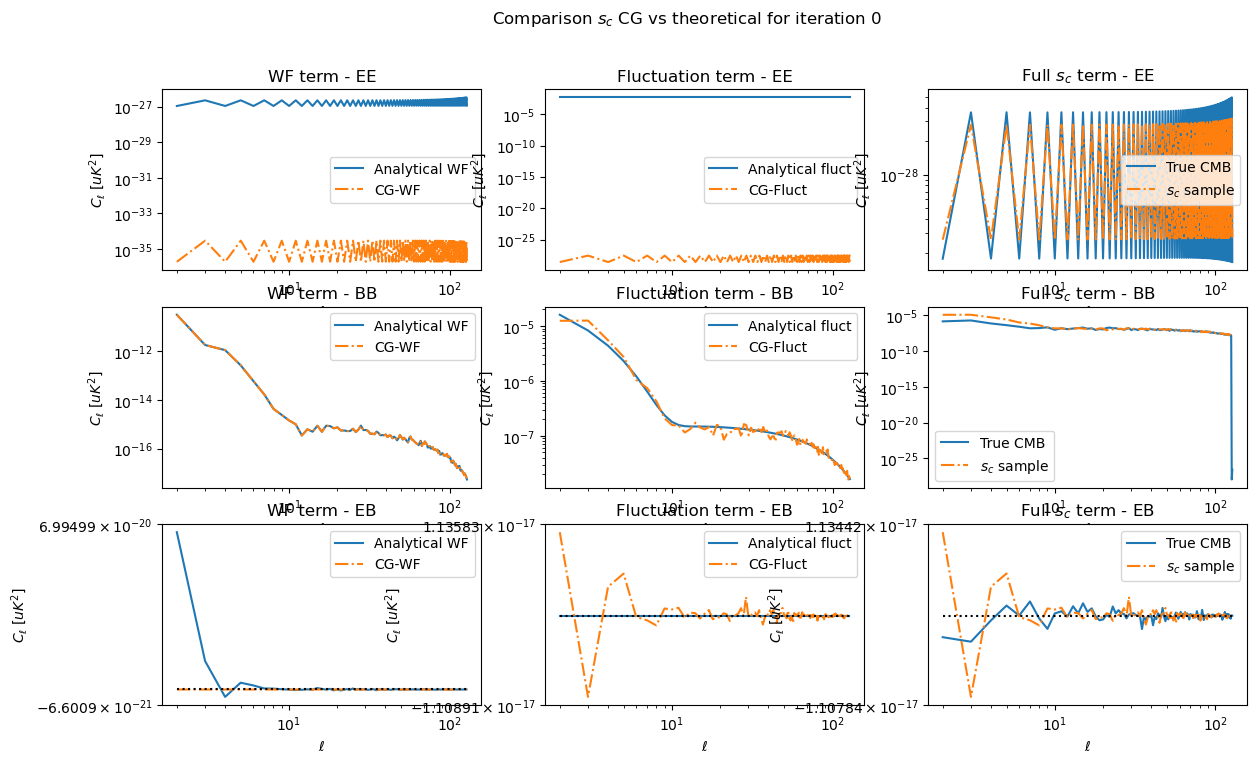

In [29]:
list_correl = ['EE', 'BB', 'EB']

map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=lmax, iter=n_iter)[indices_polar, lmin:]

covariance_noise = np.zeros_like(c_ell_true_CMB)

analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.eye(nstokes)/BtinvNB[0,0])
# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)

analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

s_c_WF_maps_extended = np.vstack([np.zeros_like(wiener_filter_term[0,...]), wiener_filter_term])
c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_fluct_maps_extended = np.vstack([np.zeros_like(fluctuation_maps[0,...]), fluctuation_maps])
c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_recovered_ext = np.vstack([np.zeros_like(s_c_sample[0]),s_c_sample])
c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

plt.figure(figsize=(14,8))
plt.suptitle(r"Comparison $s_c$ CG vs theoretical for iteration {}".format(iteration))

for j in range(number_correl_to_plot):
    plt.subplot(331+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, analytical_WF_cells[j,:], label='Analytical WF')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ells_s_c_WF[j,:], '-.', label='CG-WF')
    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('WF term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()

    plt.subplot(332+3*j)
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_fluct[j,:], '-.', label='CG-Fluct')

    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Fluctuation term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
    
    plt.subplot(333+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')

    if j <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    
    plt.xlabel(r"$\ell$")
    plt.legend()


plt.show()

In [30]:
step_size_r = 10**(-4)

n_walkers = 1
num_warmup = 0
number_steps_sampler = 10000


c_ells_Wishart = micmac.get_cell_from_map(s_c_sample, lmax=lmax, n_iter=n_iter)
# c_ells_Wishart = micmac.get_cell_from_map(input_cmb_maps[0], lmax=lmax, n_iter=n_iter)#[indices_polar]
# c_ells_Wishart = np.zeros_like(c_ells_Wishart)
# c_ells_Wishart[:,lmin:] = micmac.get_c_ells_from_red_covariance_matrix(true_red_cov_cmb_specra)

if only_select_Bmodes:
        # c_ells_Wishart[0,:] = 0
        c_ells_Wishart[2,:] = 0

kernel = micmac.MetropolisHastings_log(get_conditional_proba_C_from_r, step_size=step_size_r)
mcmc_kernel = numpyro.infer.MCMC(kernel, num_chains=n_walkers, num_warmup=num_warmup, num_samples=number_steps_sampler)


c_ells_Wishart_modified = np.copy(c_ells_Wishart)
for i in range(nstokes):
        c_ells_Wishart_modified[i] *= 2*np.arange(lmax+1) + 1
red_c_ells_Wishart_modified = micmac.get_reduced_matrix_from_c_ell(c_ells_Wishart_modified)[lmin:]

full_initial_guess = 0.01
full_initial_guess = 10**(-8)

r_samples = get_sample_parameter(mcmc_kernel, full_initial_guess, random_PRNGKey=random.PRNGKey(100), lmin=lmin, lmax=lmax, red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total)


sample: 100%|██████████| 10000/10000 [00:04<00:00, 2450.10it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      0.00      0.00      0.00      0.00      0.00    476.16      1.00



In [31]:
r_param_test_1 = 0
r_param_test_2 = 1
r_param_test_3 = 0.01
r_param_test_4 = 0.1

c_ells_Wishart_modified = np.copy(c_ells_Wishart)
for i in range(nstokes):
        c_ells_Wishart_modified[i] *= 2*np.arange(lmax+1) + 1
red_c_ells_Wishart_modified = micmac.get_reduced_matrix_from_c_ell(c_ells_Wishart_modified)[lmin:]


print(r_param_test_1, get_conditional_proba_C_from_r(r_param_test_1, red_sigma_ell=red_c_ells_Wishart_modified, lmin=lmin, lmax=lmax, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total))
print(r_param_test_2, get_conditional_proba_C_from_r(r_param_test_2, red_sigma_ell=red_c_ells_Wishart_modified, lmin=lmin, lmax=lmax, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total))
print(r_param_test_3, get_conditional_proba_C_from_r(r_param_test_3, red_sigma_ell=red_c_ells_Wishart_modified, lmin=lmin, lmax=lmax, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total))
print(r_param_test_4, get_conditional_proba_C_from_r(r_param_test_4, red_sigma_ell=red_c_ells_Wishart_modified, lmin=lmin, lmax=lmax, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total))


0 inf
1 651620.9787727738
0.01 694779.2204957982
0.1 675672.4090993209


In [32]:
log_space_r = np.logspace(-8,3, num=100)

if r_true != 0:
        log_r_true = np.log10(r_true)
        log_space_r = np.logspace(log_r_true-.1,log_r_true+.1, num=100)
else:
        log_space_r = np.logspace(-20,-2, num=100)
c_ells_Wishart_modified = np.copy(c_ells_Wishart)
for i in range(nstokes):
        c_ells_Wishart_modified[i] *= 2*np.arange(lmax+1) + 1
red_c_ells_Wishart_modified = micmac.get_reduced_matrix_from_c_ell(c_ells_Wishart_modified)[lmin:]

all_logproba_r = np.array([get_conditional_proba_C_from_r(r_logspace, red_sigma_ell=red_c_ells_Wishart_modified, lmin=lmin, lmax=lmax, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total) for r_logspace in log_space_r])

In [33]:
r_fit = r_samples[0,100:].mean()
print('R_fit :', r_fit)

R_fit : 0.0010102787788513275


In [43]:
r_max = log_space_r[np.where(all_logproba_r==all_logproba_r.max())[0][0]]
print('R_max :', r_max)

R_max : 0.00101169709987675


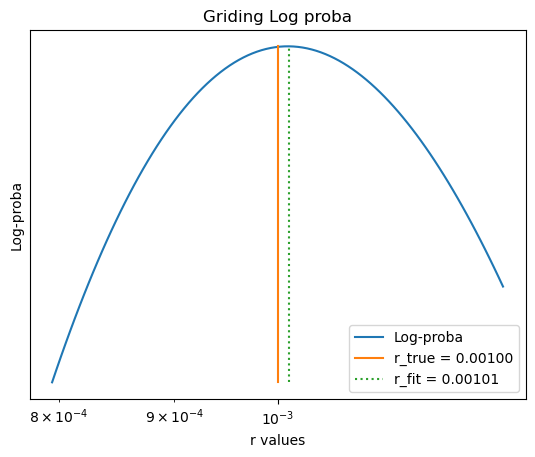

In [44]:
plt.plot(log_space_r, all_logproba_r, label='Log-proba')
plt.plot([r_true, r_true], [all_logproba_r.min(), all_logproba_r.max()], label='r_true = {:.5f}'.format(r_true))
plt.plot([r_fit, r_fit], [all_logproba_r.min(), all_logproba_r.max()], ':', label='r_fit = {:.5f}'.format(r_max))
# plt.plot([1/r_true, 1/r_true], [all_logproba_r.min(), all_logproba_r.max()], label='1/r_true')
# plt.plot([10**(2), 10**(2)], [all_logproba_r.min(), all_logproba_r.max()], label='10^2')
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel('r values')
plt.ylabel('Log-proba')
plt.title('Griding Log proba')
# plt.ylim(ymax=all_logproba_r.max())
plt.legend()
plt.show()

In [45]:
r_samples.shape

(1, 10000)

In [46]:
red_c_ells_samples = np.zeros((number_steps_sampler, lmax+1-lmin, nstokes, nstokes))

for i in range(number_steps_sampler):
    red_c_ells_samples[i,...] = theoretical_red_cov_r0_total + r_samples[0,i]*theoretical_red_cov_r1_tensor
    


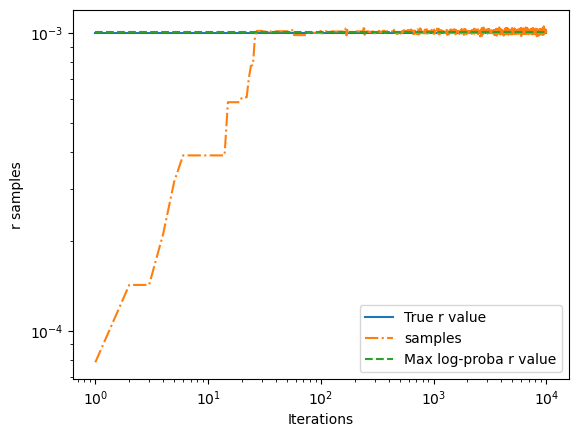

In [47]:
plt.plot([1,number_steps_sampler], [r_true,r_true], label='True r value')
plt.plot(np.arange(number_steps_sampler)+1, r_samples[0], '-.', label='samples')
plt.plot([1,number_steps_sampler], [r_max,r_max], '--', label='Max log-proba r value')
plt.xlabel('Iterations')
plt.ylabel('r samples')
plt.loglog()
plt.legend()
plt.show()

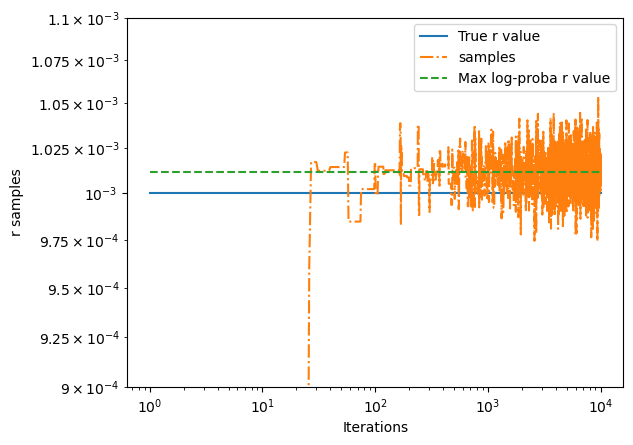

In [49]:
plt.plot([1,number_steps_sampler], [r_true,r_true], label='True r value')
plt.plot(np.arange(number_steps_sampler)+1, r_samples[0], '-.', label='samples')
plt.plot([1,number_steps_sampler], [r_max,r_max], '--', label='Max log-proba r value')
plt.xlabel('Iterations')
plt.ylabel('r samples')
plt.loglog()
plt.legend()
plt.ylim(ymin=r_true*.9, ymax=r_true*1.1)
plt.show()